In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
pretrained_weightshere = '/kaggle/input/xception_deepfakedetection/pytorch/default/1/xception_best.pth'

<ipython-input-19-7248fb785a4b>:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(config['pretrained'], map_location=torch.device('cpu'))


Predicted class: 1, Probability: 0.505712628364563


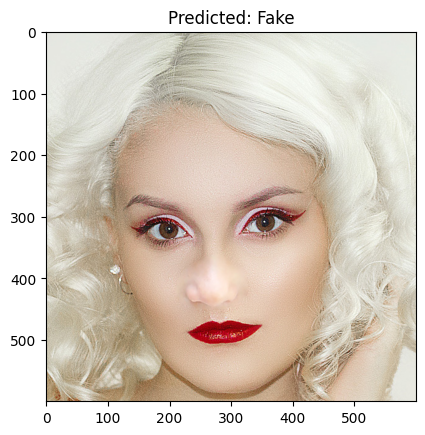

In [19]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the necessary components of the Xception network
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = self.conv1(x)
        return self.pointwise(x)

class Block(nn.Module):
    def __init__(self, in_filters, out_filters, reps, strides=1, start_with_relu=True, grow_first=True):
        super().__init__()
        self.skip = nn.Conv2d(in_filters, out_filters, 1, stride=strides, bias=False) if (out_filters != in_filters or strides != 1) else None
        self.skipbn = nn.BatchNorm2d(out_filters) if self.skip is not None else None

        self.relu = nn.ReLU(inplace=True)
        rep = []
        filters = in_filters

        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters, out_filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for _ in range(reps - 1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters, filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters, out_filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if strides != 1:
            rep.append(nn.MaxPool2d(3, strides, 1))

        self.rep = nn.Sequential(*rep)

    def forward(self, x):
        skip = self.skip(x) if self.skip is not None else x
        if self.skipbn is not None:
            skip = self.skipbn(skip)
        return self.rep(x) + skip

class Xception(nn.Module):
    def __init__(self, num_classes=2, inc=3, dropout=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(inc, 32, 3, 2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32, 64, 3, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.block1 = Block(64, 128, 2, 2, start_with_relu=False, grow_first=True)
        self.block2 = Block(128, 256, 2, 2, start_with_relu=True, grow_first=True)
        self.block3 = Block(256, 728, 2, 2, start_with_relu=True, grow_first=True)

        self.block4 = Block(728, 728, 3, 1, start_with_relu=True, grow_first=True)
        self.block12 = Block(728, 1024, 2, 2, start_with_relu=True, grow_first=False)

        self.conv3 = SeparableConv2d(1024, 1536, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(1536)
        self.conv4 = SeparableConv2d(1536, 2048, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.last_linear = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block12(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = torch.mean(x, dim=[2, 3])  # Global average pooling
        x = self.last_linear(x)
        return x

# Define the XceptionDetector class
class XceptionDetector(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.backbone = Xception(
            num_classes=config['backbone_config']['num_classes'],
            inc=config['backbone_config']['inc'],
            dropout=config['backbone_config']['dropout']
        )
        state_dict = torch.load(config['pretrained'], map_location=torch.device('cpu'))
        self.backbone.load_state_dict(state_dict, strict=False)

    def forward(self, data_dict):
        return self.backbone(data_dict['image'])

# Load the test image
image_path = '/kaggle/input/deepfake-detection/real_and_fake_face_detection/real_and_fake_face/training_fake/easy_115_0010.jpg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')

# Define the transformations (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize to the input size of Xception (299x299)
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Apply the transformations to the image
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Define the configuration for the model
config = {
    'backbone_config': {
        'num_classes': 2,  # Assuming 2 classes (real vs fake)
        'inc': 3,  # RGB image
        'dropout': 0.5,
    },
    'pretrained': '/kaggle/input/xception_deepfakedetection/pytorch/default/1/xception_best.pth',  # Path to pretrained weights
}

# Initialize the model
model = XceptionDetector(config)

# Set the model to evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    outputs = model({'image': image_tensor})

# Extract the predicted probabilities and class
probabilities = torch.softmax(outputs, dim=1)
prediction = torch.argmax(probabilities).item()  # Get predicted class index

# Print the result
print(f"Predicted class: {prediction}, Probability: {probabilities.max().item()}")

# Optional: Show the image with the prediction
plt.imshow(image)
plt.title(f"Predicted: {'Fake' if prediction == 1 else 'Real'}")
plt.show()

<ipython-input-19-7248fb785a4b>:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(config['pretrained'], map_location=torch.device('cpu'))


Probability of Real: 0.5002052187919617
Probability of Fake: 0.49979475140571594


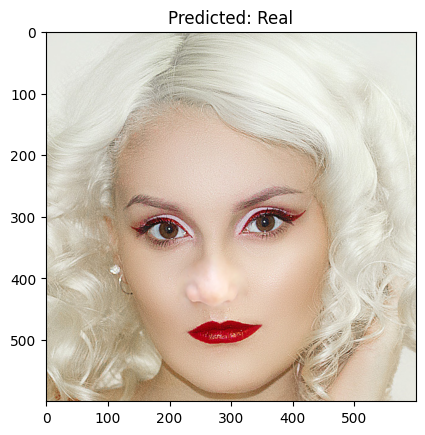

In [21]:
# import torch
# import torch.nn as nn
# from torchvision import transforms
# from PIL import Image
# import matplotlib.pyplot as plt
# import random
# import numpy as np

# # Set seeds for reproducibility
# torch.manual_seed(0)
# np.random.seed(0)
# random.seed(0)

# # For CUDA (if applicable)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# # Define the necessary components of the Xception network
# # ... (Xception and XceptionDetector class definitions remain unchanged) ...

# # Load the test image
# image_path = '/kaggle/input/deepfake-detection/real_and_fake_face_detection/real_and_fake_face/training_fake/easy_115_0010.jpg'  # Replace with your image path
# image = Image.open(image_path).convert('RGB')

# # Define the transformations (resize, normalize, etc.)
# transform = transforms.Compose([
#     transforms.Resize((299, 299)),  # Resize to the input size of Xception (299x299)
#     transforms.ToTensor(),  # Convert to tensor
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
# ])

# # Apply the transformations to the image
# image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# # Define the configuration for the model
# config = {
#     'backbone_config': {
#         'num_classes': 2,  # Assuming 2 classes (real vs fake)
#         'inc': 3,  # RGB image
#         'dropout': 0.5,
#     },
#     'pretrained': pretrained_weightshere,  # Path to pretrained weights
# }

# # Initialize the model
# model = XceptionDetector(config)

# # Set the model to evaluation mode
# model.eval()

# # Perform inference
# with torch.no_grad():
#     outputs = model({'image': image_tensor})

# # Extract the predicted probabilities for both classes
# probabilities = torch.softmax(outputs, dim=1).squeeze()  # Remove batch dimension

# # Print the probabilities for both classes
# print(f"Probability of Real: {probabilities[0].item()}")
# print(f"Probability of Fake: {probabilities[1].item()}")

# # Optional: Show the image with the prediction
# plt.imshow(image)
# plt.title(f"Predicted: {'Fake' if probabilities[1] > probabilities[0] else 'Real'}")
# plt.show()